# Análisis de datos y selección de características en el Boston Dataset

En este cuaderno, vamos a realizar una selección de técnicas exploratorias de los datos, a la vez que una implementación de una técnica de selección de características conocida como [*backward elimination*](https://towardsdatascience.com/backward-elimination-for-feature-selection-in-machine-learning-c6a3a8f8cef4).

## Importación de módulos y carga del dataset

Importamos la mayoría de módulos necesarios (importaremos alguno más bajo demanda según vayamos progresando en el cuaderno):

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
import seaborn as sns

Para realizar la eliminación hacia atrás, necesitaremos un nuevo módulo que no está cargado en nuestro entorno. Procedemos a instalarlo en él con conda:

In [ ]:
!conda install -y --name ks-sl statsmodels

Ahora, cargamos el dataset:

In [6]:
# Cargamos el dataset, tipo Scikit-Learn Bunch
boston_data = load_boston()

# Lo convertimos a un DataFrame de Pandas
df_boston = pd.DataFrame(np.column_stack((boston_data.data, boston_data.target)),columns = np.append(boston_data.feature_names,['TARGET']))

## Exploración inicial

Echamos un vistazo a los datos en el dataset:

In [7]:
df_boston.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


Echamos también un vistazo al número de instancias (muestras) y características que tenemos:

In [8]:
df_boston.shape

(506, 14)

Por último, visualizamos una serie de parámetros estadísticos que son útiles para conocer la distribución de los datos:

In [9]:
df_boston.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


## Análisis de valores que faltan

Un ejercicio necesario es saber si hay valores que faltan. Éstos valores están representados en Pandas por `np.nan`. Pandas nos ofrece una manera de saber qué características los tienen:

In [10]:
pd.isnull(df_boston).any()

CRIM       False
ZN         False
INDUS      False
CHAS       False
NOX        False
RM         False
AGE        False
DIS        False
RAD        False
TAX        False
PTRATIO    False
B          False
LSTAT      False
TARGET     False
dtype: bool

No tenemos ningún valor que falte. Si lo tuviésemos, Pandas nos da la manera de saber el conteo de dichos valores que faltan:

In [11]:
pd.isnull(df_boston).sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
TARGET     0
dtype: int64

Recordemos que, por último, tenemos que analizar si tenemos valores que son cero, y si éstos tienen sentido en el contexto de la medida que expresa la característica. Vamos a buscar si tenemos características que tienen valor cero: 

In [13]:
df_boston.isin([0]).sum()

CRIM         0
ZN         372
INDUS        0
CHAS       471
NOX          0
RM           0
AGE          0
DIS          0
RAD          0
TAX          0
PTRATIO      0
B            0
LSTAT        0
TARGET       0
dtype: int64

Sólo ZN y CHAS los tienen: para saber si el cero tiene sentido en el contexto de la característica, vamos a preguntarle a la información del dataset de Scikit-Learn y entender el significado:

In [14]:
print(boston_data.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

Vamos que un valor cero tiene sentido tanto para ZN como CHAS, así que concluimos que no es indicativo de un valor que falte. Si hubiésemos tenido el caso de valores que faltan, ya sea representados correctamente por `nan` o por ceros, tendríamos que proceder a sustituir esos valores con la técnica que ya hemos ilustrado en [el ejercicio de kNNs para predicción de diabetes](kNNs_Exercise_Solutions.ipynb).

## Correlación entre atributos

Es bastante útil saber si hay pares de características que están correladas y cuánto. Para algunos algoritmos de Machine Learning suponen un problema, e idealmente deberíamos limpiar los datos para tener un conjunto de características que sean independientes. Recordemos que la correlación es un problema sólo para algunos tipos de algoritmos (regresión lineal, regresión logística), y puede llegar a ocultar interacciones interesantes en los datos entre diferentes características en los Random Forests. La correlación entre una característica y nuestro objetivo siempre es interesante y nos interesa mantenerla.

En otros casos, la correlación entre características no se traduce en un detrimento del comportamiento del modelo. Por ejemplo, Naive Bayes puede beneficiarse de características que esté correladas entre sí positivamente.

Pandas nos ofrece tres coeficientes de medida de correlación a través de `DataFrame.corr()`:

 - Coeficiente de Pearson
 - Tau de Kendall
 - Correlación de Spearman

`DataFrame.corr()` devuelve otro DataFrame con los pares de características en el rango [-1,1], con un significado de 1 para correlación total, -1 para correlación negativa, y 0 para ninguna correlación: 

In [15]:
df_boston.corr(method='pearson')

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
CRIM,1.000000,-0.200469,0.406583,-0.055892,0.420972,-0.219247,0.352734,-0.379670,0.625505,0.582764,0.289946,-0.385064,0.455621,-0.388305
ZN,-0.200469,1.000000,-0.533828,-0.042697,-0.516604,0.311991,-0.569537,0.664408,-0.311948,-0.314563,-0.391679,0.175520,-0.412995,0.360445
INDUS,0.406583,-0.533828,1.000000,0.062938,0.763651,-0.391676,0.644779,-0.708027,0.595129,0.720760,0.383248,-0.356977,0.603800,-0.483725
CHAS,-0.055892,-0.042697,0.062938,1.000000,0.091203,0.091251,0.086518,-0.099176,-0.007368,-0.035587,-0.121515,0.048788,-0.053929,0.175260
NOX,0.420972,-0.516604,0.763651,0.091203,1.000000,-0.302188,0.731470,-0.769230,0.611441,0.668023,0.188933,-0.380051,0.590879,-0.427321
RM,-0.219247,0.311991,-0.391676,0.091251,-0.302188,1.000000,-0.240265,0.205246,-0.209847,-0.292048,-0.355501,0.128069,-0.613808,0.695360
AGE,0.352734,-0.569537,0.644779,0.086518,0.731470,-0.240265,1.000000,-0.747881,0.456022,0.506456,0.261515,-0.273534,0.602339,-0.376955
DIS,-0.379670,0.664408,-0.708027,-0.099176,-0.769230,0.205246,-0.747881,1.000000,-0.494588,-0.534432,-0.232471,0.291512,-0.496996,0.249929
RAD,0.625505,-0.311948,0.595129,-0.007368,0.611441,-0.209847,0.456022,-0.494588,1.000000,0.910228,0.464741,-0.444413,0.488676,-0.381626
TAX,0.582764,-0.314563,0.720760,-0.035587,0.668023,-0.292048,0.506456,-0.534432,0.910228,1.000000,0.460853,-0.441808,0.543993,-0.468536


Nótese que computacionalmente, los tres métodos de calculo de correlación difieren bastante:

In [16]:
for method in ['pearson', 'kendall', 'spearman']:
    print("Metrics for", method)
    # Magic de iPython para hacer benchmarking de un comando
    %timeit df_boston.corr(method)

Metrics for pearson
414 µs ± 5.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
Metrics for kendall
32.6 ms ± 762 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
Metrics for spearman
11 ms ± 210 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Además de la correlación entre las características, también queremos saber la correlación entre las características y los valores objetivo, es decir, cómo es cada valor de entrada capaza de predecir nuestro objetivo:

In [17]:
pearson = df_boston.corr(method='pearson')
# Los objetivos son la última columna, eliminamos también la correlación consigo mismos
corr_with_target = pearson.ix[-1][:-1]
# Ahora ordenamos con los que mejor predicen primero
predictiviy = corr_with_target.sort_values(ascending=False)

In [18]:
predictiviy

RM         0.695360
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
AGE       -0.376955
RAD       -0.381626
CRIM      -0.388305
NOX       -0.427321
TAX       -0.468536
INDUS     -0.483725
PTRATIO   -0.507787
LSTAT     -0.737663
Name: TARGET, dtype: float64

Ya que puede que estemos interesados en las correlaciones negativas, usemos `argsort` para hacer un listado inverso de las características y ver cuál está más fuertemente correlada negativamente:

In [19]:
corr_with_target[abs(corr_with_target).argsort()[::-1]]

LSTAT     -0.737663
RM         0.695360
PTRATIO   -0.507787
INDUS     -0.483725
TAX       -0.468536
NOX       -0.427321
CRIM      -0.388305
RAD       -0.381626
AGE       -0.376955
ZN         0.360445
B          0.333461
DIS        0.249929
CHAS       0.175260
Name: TARGET, dtype: float64

Todo esto está muy bien, pero podemos apoyarnos en librerías de visualización como Seaborn para visualizar el análisis exploratorio de los datos.

Primero, pintamos la distribución de la variable objetivo usando la función `distplot` de Seaborn:

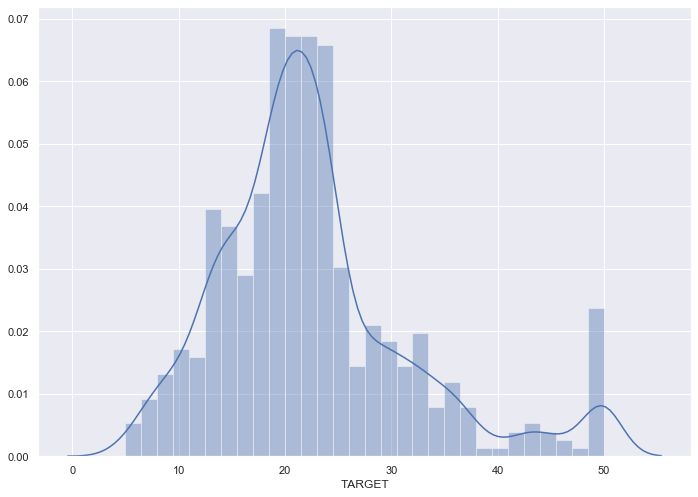

In [20]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.distplot(df_boston.TARGET, bins=30)
plt.show()


Puede verse que los valores de los precios están distribuidos normalmente, con algunos outliers. Para el análisis de correlación que hicimos más arriba, podemos usar la función `heatmap` de seaborn:

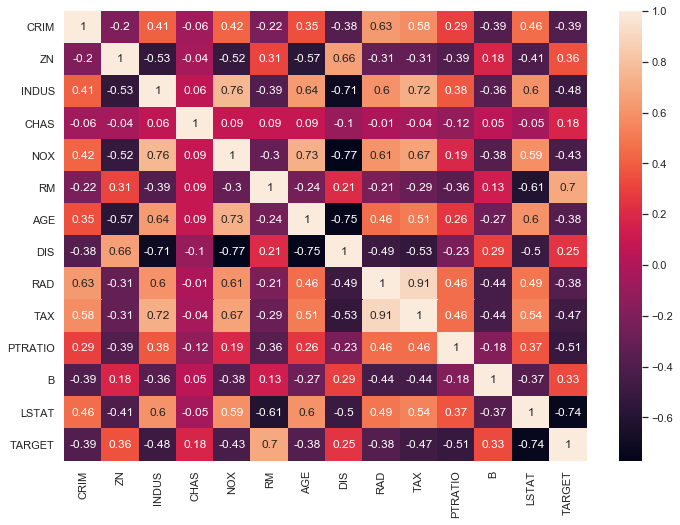

In [21]:
correlation_matrix = pearson.round(2)
sns.heatmap(data=correlation_matrix, annot=True)

Gráficamente vemos lo mismo que veíamos en la tabla de correlación previa:

- `RM` tiene una correlación positiva fuerte con nuestro objetivo, mientras que `LSTAT` tiene una correlación negativa fuerte con él.
- En lo que se refiere a características fuertemente correladas entre ellas, vemos que `RAD` y `TAX` tienen una correlación que está por encima del 0.9, en particular 0.91. Esto indica que no deberíamos seleccionar ambar características conjuntamente  a la hora de entrenar el modelo.

## Selección de características - Correlación y P value
### Eliminación de características altamente correladas

Lo que hemos hecho arriba para analizar la correlación cruzada y eliminar variables redundantes, lo podemos hacer de manera automática con el siguiente código, que itera entre los pares de características buscando por correlaciones que superan un umbral `CORR_THRESHOLD` que típicamente es del 90%. Cuando esto ocurre, elimina una de las dos características altamente correladas, en este caso `TAX`:

In [22]:
CORR_THRESHOLD = 0.9

columns = np.full((pearson.shape[0],), True, dtype=bool)

for i in range(pearson.shape[0]):
    for j in range(i+1, pearson.shape[0]):
        if pearson.iloc[i,j] >= CORR_THRESHOLD:
            if columns[j]:
                columns[j] = False

selected_columns = df_boston.columns[columns]
# data es el dataframe que almacena el resultado de la eliminación de características
# altamente correladas
data = df_boston[selected_columns]

Mostramos las columnas restantes viendo que, efectivamente, nos hemos dejado una por el camino:

In [23]:
selected_columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD',
       'PTRATIO', 'B', 'LSTAT', 'TARGET'],
      dtype='object')

### Selección de las columnas según los p-Values

La selección de columnas según sus p-Values que ocurre en la eliminación hacia atrás se debe a la validación de la hipótesis de que una característica tiene o no efecto en el resultado de la predicción. Es decir, eliminar diferentes características del dataset tendrá diferentes efectos en el p-Value para el dataset.

Lo que podemos hacer es ir eliminando características y medir el p-Value en cada caso. Los p-Values medidos nos pueden servir entonces para determinar qué características conservar y cuáles eliminar. Para entender algo más sobre cómo se utilizan los p-Calues en la validación de hipótesis sobre los datos con este artículo: [The Null hypothesis and the p-Value](https://towardsdatascience.com/null-hypothesis-and-the-p-value-fdc129db6502)

Lo primero que vamos a hacer es eliminar la columna objetivo, ya que no será objeto de nuestro análisis:

In [24]:
# Quitamos la columna objetivo
selected_columns = selected_columns[:-1].values

Comprobamos que las columnas que nos quedan son efectivamente nuestras características:

In [25]:
print(selected_columns)

['CRIM' 'ZN' 'INDUS' 'CHAS' 'NOX' 'RM' 'AGE' 'DIS' 'RAD' 'PTRATIO' 'B'
 'LSTAT']


Ahora importamos un modelo de regresión lineal del paquete statsmodel, que nos permitirá obtener los p-Values de los predictores (cosa que no tenemos disponible en la implementación de regresión lineal de Scikit-Learn):

In [26]:
import statsmodels.regression.linear_model as sm

Creamos una función Python que implementa la eliminación hacia atrás tal y como está definida en el flujograma de la técnica que estamos siguiendo:

![Backward elimination](./../images/backward-elimination.png)


In [27]:
def backwardElimination(x, Y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(Y, x).fit()
        maxVar = max(regressor_OLS.pvalues).astype(float)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns

In [28]:
SL = 0.05
data_modeled, selected_columns = backwardElimination(data.iloc[:,:-1].values, data.iloc[:,-1].values, SL, selected_columns)

Movemos los resultados a un nuevo dataframe:

In [29]:
result = pd.DataFrame()
result['TARGET'] = data.TARGET

Y también movemos nuestros nuevos datos:

In [30]:
data = pd.DataFrame(data = data_modeled, columns=selected_columns)

In [31]:
data.describe()

,CRIM,ZN,CHAS,NOX,RM,DIS,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,0.069170,0.554695,6.284634,3.795043,18.455534,356.674032,12.653063
std,8.601545,23.322453,0.253994,0.115878,0.702617,2.105710,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.000000,0.385000,3.561000,1.129600,12.600000,0.320000,1.730000
25%,0.082045,0.000000,0.000000,0.449000,5.885500,2.100175,17.400000,375.377500,6.950000
50%,0.256510,0.000000,0.000000,0.538000,6.208500,3.207450,19.050000,391.440000,11.360000
75%,3.677083,12.500000,0.000000,0.624000,6.623500,5.188425,20.200000,396.225000,16.955000
max,88.976200,100.000000,1.000000,0.871000,8.780000,12.126500,22.000000,396.900000,37.970000


### Escalado de los datos

A efectos de comparación de resultados, vamos a entrenar un model SVM de regresión. Como vimos en clase, estos modelos son extremadamente sensibles a la escala de los datos. Por eso, vamos a proceder a utilizar un `minmaxscaler` sobre los mismos:

In [32]:
from sklearn.preprocessing import MinMaxScaler

# Aplicamos un MinMaxScaler para escalar las características bajo un mismo criterio
data_scaled = MinMaxScaler().fit_transform(data)

# Entrenamiento de modelos
Finalmente, entrenamos nuestro modelo SVR, que será lo más parecido al entrenamiento de un modelo lineal con regularización sobre un dataset extendido con `PolynomialFeatures`, tal y como hicimos en clase en la sección de modelos lineales:

In [33]:
X_train, X_test, y_train, y_test = train_test_split(data_scaled, result.values, test_size = 0.2, random_state=10)

Entrenamos el modelo con un cierto ajuste de los parámetros del Radial Basis Function kernel:

In [34]:
from sklearn.svm import SVR
svr = SVR(C=1000, kernel='rbf', gamma=2)
svr.fit(X_train, y_train)

SVR(C=1000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=2,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
Por último, mostramos el score en training y test:

In [36]:
print("Score en training: ", svr.score(X_train,y_train))
print("Score en test: ", svr.score(X_test, y_test))

Score en training:  0.9468246788391159
Score en test:  0.8684011295947553


Si recordamos o echamos un vistazo a los modelos regularizados lineales (Ridge, Lasso) que usamos sobre el dataset Boston extendido, vemos que el resultado que obtenemos aquí es ligeramente mejor.